# KDD  — UCI Adult (Census Income)
Workflow: **Selection → Preprocessing → Transformation → Data Mining → Interpretation/Evaluation**.
Predict income >$50K using the Adult dataset.

## Environment Setup

In [1]:

!pip -q install pandas numpy scikit-learn matplotlib ucimlrepo --quiet
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, average_precision_score, roc_curve,
                             precision_recall_curve, confusion_matrix, classification_report,
                             brier_score_loss)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from ucimlrepo import fetch_ucirepo


## 1) Selection

In [2]:

adult = fetch_ucirepo(id=2)
X_raw = adult.data.features.copy()
y_raw = adult.data.targets.copy()

X_raw.columns = [c.strip().replace('-', '_').replace(' ', '_') for c in X_raw.columns]
y_col = y_raw.columns[0]
y = y_raw[y_col].astype(str).str.strip()
y = y.apply(lambda s: 1 if s in {">50K", ">50K."} else 0).astype(int)

print("Shape:", X_raw.shape, "Pos rate:", round(float(y.mean()),4))

X_train_full, X_test, y_train_full, y_test = train_test_split(X_raw, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=42)
print("Splits:", X_train.shape, X_valid.shape, X_test.shape)


Shape: (48842, 14) Pos rate: 0.2393
Splits: (29304, 14) (9769, 14) (9769, 14)


## 2) Preprocessing

In [3]:

X_train = X_train.replace('?', np.nan)
X_valid = X_valid.replace('?', np.nan)
X_test  = X_test.replace('?', np.nan)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric:", len(numeric_cols), "Categorical:", len(categorical_cols))

display(X_train[numeric_cols].describe().T.head(10))
display(X_train.isna().mean().sort_values(ascending=False).head(10))


Numeric: 6 Categorical: 8


,count,mean,std,min,25%,50%,75%,max
age,29304.0,38.607733,13.655944,17.0,28.00,37.0,47.0,90.0
fnlwgt,29304.0,189683.728979,105429.051456,13769.0,117564.25,178553.5,237676.0,1490400.0
education_num,29304.0,10.054395,2.566664,1.0,9.00,10.0,12.0,16.0
capital_gain,29304.0,1083.634453,7479.363395,0.0,0.00,0.0,0.0,99999.0
capital_loss,29304.0,85.117288,397.757085,0.0,0.00,0.0,0.0,4356.0
hours_per_week,29304.0,40.525287,12.449385,1.0,40.00,40.0,45.0,99.0


,0
occupation,0.057057
workclass,0.056886
native_country,0.018086
education,0.000000
fnlwgt,0.000000
age,0.000000
marital_status,0.000000
education_num,0.000000
race,0.000000
relationship,0.000000


## 3) Transformation

In [4]:

skew_candidates = [c for c in ['capital_gain', 'capital_loss', 'fnlwgt'] if c in numeric_cols]

def log1p_selected(X_df):
    X_df = pd.DataFrame(X_df, columns=numeric_cols).copy()
    for c in skew_candidates:
        if c in X_df.columns:
            arr = pd.to_numeric(X_df[c], errors='coerce').fillna(0).values
            arr = np.where(arr < 0, 0, arr)
            X_df[c] = np.log1p(arr)
    return X_df.values

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(log1p_selected, validate=False)),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, numeric_cols),
    ('cat', categorical_pipe, categorical_cols)
])

Xt = preprocess.fit_transform(X_train, y_train)
Xv = preprocess.transform(X_valid)
Xs = preprocess.transform(X_test)
Xt.shape, Xv.shape, Xs.shape


((29304, 63), (9769, 63), (9769, 63))

## 4) Data Mining

In [5]:

def fit_and_eval(model, param_grid, name):
    pipe = Pipeline([('prep', preprocess), ('clf', model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    search.fit(X_train, y_train)
    best = search.best_estimator_
    proba = best.predict_proba(X_valid)[:,1]
    roc = roc_auc_score(y_valid, proba)
    ap = average_precision_score(y_valid, proba)
    print(f"\n{name}: ROC-AUC(Valid)={roc:.3f} AP={ap:.3f}")
    print("Best params:", search.best_params_)
    return best, proba, {'roc_auc': roc, 'ap': ap}

results = {}
lr_model, lr_proba, lr_metrics = fit_and_eval(
    LogisticRegression(max_iter=2000, class_weight='balanced'),
    {'clf__C':[0.25,0.5,1.0,2.0], 'clf__solver':['lbfgs']}, 'Logistic Regression')
results['LogReg'] = lr_metrics

rf_model, rf_proba, rf_metrics = fit_and_eval(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    {'clf__n_estimators':[300,600], 'clf__max_depth':[None,12,18], 'clf__min_samples_leaf':[1,3,5]}, 'Random Forest')
results['RandomForest'] = rf_metrics

hgb_model, hgb_proba, hgb_metrics = fit_and_eval(
    HistGradientBoostingClassifier(random_state=42, max_bins=255, learning_rate=0.1),
    {'clf__max_depth':[None,3,6], 'clf__learning_rate':[0.05,0.1,0.2]}, 'HistGradientBoosting')
results['HGB'] = hgb_metrics

results



Logistic Regression: ROC-AUC(Valid)=0.899 AP=0.732
Best params: {'clf__C': 1.0, 'clf__solver': 'lbfgs'}


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Random Forest: ROC-AUC(Valid)=0.915 AP=0.794
Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 600}

HistGradientBoosting: ROC-AUC(Valid)=0.928 AP=0.827
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6}


{'LogReg': {'roc_auc': np.float64(0.8992362589834612),
  'ap': np.float64(0.7318232796897708)},
 'RandomForest': {'roc_auc': np.float64(0.9153584713641596),
  'ap': np.float64(0.7943777793761011)},
 'HGB': {'roc_auc': np.float64(0.9278810811520388),
  'ap': np.float64(0.8274975836828199)}}

## 5) Interpretation & Evaluation

Selected best: HGB {'roc_auc': np.float64(0.9278810811520388), 'ap': np.float64(0.8274975836828199)}
Test — ROC-AUC=0.929 AP=0.832 Brier=0.088
Threshold: 0.24
Confusion matrix:
 [[6058 1373]
 [ 312 2026]]

Classification report:
               precision    recall  f1-score   support

           0      0.951     0.815     0.878      7431
           1      0.596     0.867     0.706      2338

    accuracy                          0.828      9769
   macro avg      0.774     0.841     0.792      9769
weighted avg      0.866     0.828     0.837      9769



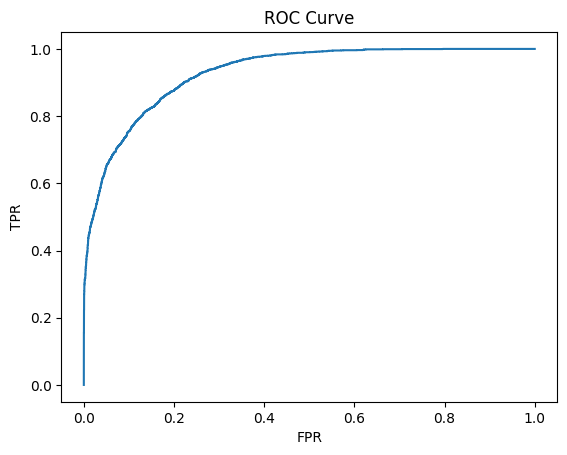

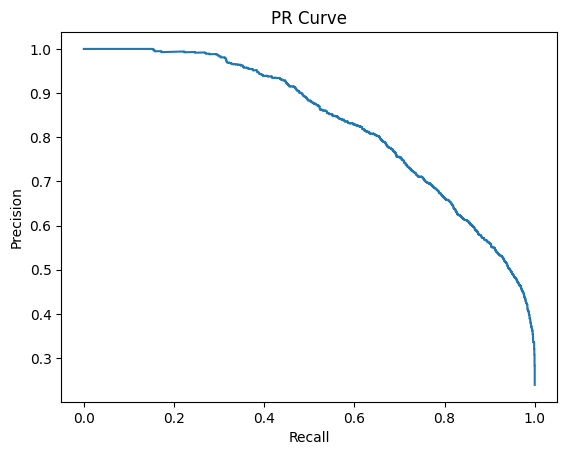

In [6]:

from sklearn.calibration import CalibratedClassifierCV
best_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = {'LogReg': lr_model, 'RandomForest': rf_model, 'HGB': hgb_model}[best_name]
print("Selected best:", best_name, results[best_name])

calibrated = CalibratedClassifierCV(best_model, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)
proba_test = calibrated.predict_proba(X_test)[:,1]

roc = roc_auc_score(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)
brier = brier_score_loss(y_test, proba_test)
print(f"Test — ROC-AUC={roc:.3f} AP={ap:.3f} Brier={brier:.3f}")

# Threshold via Youden's J
fpr, tpr, thr = roc_curve(y_test, proba_test)
thr_star = thr[np.argmax(tpr - fpr)]
y_pred = (proba_test >= thr_star).astype(int)

print('Threshold:', round(float(thr_star),3))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred, digits=3))

# Plots
import matplotlib.pyplot as plt
plt.figure(); plt.plot(fpr, tpr); plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.show()

pr, rc, _ = precision_recall_curve(y_test, proba_test)
plt.figure(); plt.plot(rc, pr); plt.title('PR Curve'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.show()


## Artifacts

In [7]:

import joblib, json
from datetime import datetime
from pathlib import Path

root = Path('/mnt/data/kdd_adult')
(root/'models').mkdir(parents=True, exist_ok=True)
(root/'notebooks').mkdir(parents=True, exist_ok=True)

joblib.dump(calibrated, root/'models'/'adult_income_kdd_calibrated.joblib')

card = {
    "name": f"adult_income_{best_name.lower()}_calibrated",
    "version": "1.0.0",
    "created": datetime.utcnow().isoformat()+"Z",
    "phases": ["Selection","Preprocessing","Transformation","Data Mining","Interpretation/Evaluation"],
    "metrics_test": {"roc_auc": float(roc), "ap": float(ap), "brier": float(brier)},
    "threshold": float(thr_star)
}
with open(root/'MODEL_CARD.json', 'w') as f:
    json.dump(card, f, indent=2)

print("Repo scaffold at:", root)


Repo scaffold at: /mnt/data/kdd_adult


/tmp/ipython-input-1369577544.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created": datetime.utcnow().isoformat()+"Z",
